<a href="https://colab.research.google.com/github/hsuanchia/Image-caption/blob/main/imgcap_0427.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import json,re
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Model,load_model
from keras.layers import LSTM,TimeDistributed,Dense,Embedding,Input
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from PIL import Image 
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 匯入資料

In [3]:
# Load Data
img_path = '/content/drive/MyDrive/MSCOCO_2017/val2017'
anno_path = '/content/drive/MyDrive/MSCOCO_2017/2017_annotations/captions_val2017.json'
input_file = open(anno_path)
annotation = json.load(input_file)

#處理 Caption data 

In [4]:
# 處理caption: 全部都轉成小寫加上用regular expression刪掉標點符號
def preprocess(text):
  text = text.lower()
  tmp = re.split('\W+',text)
  return tmp

In [5]:
start= "sss"
end = "eee"

In [6]:
max_length = 30
tmp = ""
sentence = []
# 對所有的caption都做處理並加上start end 的 token
for x in annotation['annotations']:
  tmp = preprocess(x['caption'])
  tmp = " ".join(tmp)
  x['caption'] = start + " " + tmp + " " + end
  sentence.append(x['caption'])
# 做Tokenize
token = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',num_words=10000)
token.fit_on_texts(sentence)
word_index = token.word_index
inv_word_index = {v: k for k, v in word_index.items()}
voc_size = len(word_index) + 1 #從1開始算 所以總數要加1

In [ ]:
print(annotation['annotations'][0])
print(annotation['images'][0])

{'image_id': 179765, 'id': 38, 'caption': 'sss a black honda motorcycle parked in front of a garage  eee'}
{'license': 4, 'file_name': '000000397133.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-14 17:02:52', 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', 'id': 397133}


#處理圖片

In [7]:
def load_image(path, size=None):
  """
  Load the image from the given file-path and resize it
  to the given size if not None.
  """
  # Load the image using PIL.
  img = Image.open(path)

  # Resize image if desired.
  img = img.resize(size=(224,224), resample=Image.LANCZOS)

  # Convert image to numpy array.
  img = np.array(img)

  # Scale image-pixels so they fall between 0.0 and 1.0
  img = img / 255.0

  # Convert 2-dim gray-scale array to 3-dim RGB array.
  if (len(img.shape) == 2):
      img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
  return img

#Encoder

In [8]:
image_model = VGG16(include_top=True,weights='imagenet')
image_model.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [9]:
img_size = K.int_shape(image_model.input)[1:3]
transfer_layer = image_model.get_layer('fc2')
encoder_model = Model(inputs=image_model.input,outputs=transfer_layer.output)
value_size = K.int_shape(transfer_layer.output)[1]

#Decoder

In [ ]:
inputs1 = Input(shape=(4096,))
fe1 = Dense(256)(inputs1)

inputs2 = Input(shape=(max_length,voc_size))
#se1 = Embedding(voc_size, 256, mask_zero=False)(inputs2)
se2 = LSTM(256,return_sequences=True,return_state=False,name='LSTM1')(inputs2,initial_state=[fe1,fe1])
#se3 = Dense(voc_size)(se2)
decode1 = TimeDistributed(Dense(voc_size, activation='softmax'))(se2)

model = Model(inputs=[inputs1, inputs2], outputs=decode1)
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
# summarize model
model.summary()
plot_model(model, to_file='model_1.png', show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 30, 7181)]   0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          1048832     input_2[0][0]                    
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 30, 256)      7616512     input_3[0][0]                    
                                                                 dense[0][0]                

NameError: ignored

#Data generator

In [ ]:
def data_generator(batch_num):
  x1, x2, y = list(), list(), list()
  n=0
  for cap in annotation['annotations']:
    n += 1
    tmp = ""
    for x in range(12-len((str)(cap['image_id']))): #檔名為000000001234.jpg,前面補0後面加上image_id + .jpg
      tmp += "0"
    tmp += (str)(cap['image_id']) + ".jpg"
    tmp_path = img_path + '/' + tmp  
    img = load_image(tmp_path) #讀image
    #print(img)
    image_batch = np.expand_dims(img, axis=0) #要做predict還要再多1個dimension,請看encoder的input
    photo = encoder_model.predict(image_batch,verbose=0) 
    seq = [word_index[word] for word in cap['caption'].split(' ') if word in word_index]  #做斷詞並將詞轉成label
    
    in_seq, out_seq = seq[:-1], seq[1:] #ex. in_seq = [1,2,3,4,5] out_seq = [2,3,4,5]
    #做padding將句子用0補在後面補到max_length
    in_seq = pad_sequences([in_seq],maxlen=max_length,padding='post')[0]
    out_seq = pad_sequences([out_seq],maxlen=max_length,padding='post')[0]
    out_seq = to_categorical([out_seq], num_classes=voc_size)[0] #因為output是機率分布，所以要再轉one-hot, dim=voc_size

    #print(in_seq,out_seq)
    x1.append(photo[0])
    x2.append(in_seq)
    y.append(out_seq)
    print(n,'/',batch_num)
    if n == batch_num:
      #print([np.array(x1), np.array(x2)], np.array(y))
      return ([np.array(x1), np.array(x2)], np.array(y)) 
      #return 就會是前batch_num筆資料
      #yield 就會是從上次for迴圈做到的地方繼續取batch_num筆資料

In [ ]:
trainx, trainy = data_generator(500)
#print(trainx)
#print(trainy)

KeyboardInterrupt: ignored

# 訓練Model

In [ ]:
model.fit(trainx,trainy,epochs=100)

Epoch 1/100
16/16 [==============================] - 26s 1s/step - loss: 3.0305 - categorical_accuracy: 0.0439
Epoch 2/100
16/16 [==============================] - 22s 1s/step - loss: 1.9709 - categorical_accuracy: 0.0582
Epoch 3/100
16/16 [==============================] - 22s 1s/step - loss: 1.8848 - categorical_accuracy: 0.0789
Epoch 4/100
16/16 [==============================] - 22s 1s/step - loss: 1.8661 - categorical_accuracy: 0.0763
Epoch 5/100
16/16 [==============================] - 22s 1s/step - loss: 1.8485 - categorical_accuracy: 0.0753
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 1.8656 - categorical_accuracy: 0.0782
Epoch 7/100
16/16 [==============================] - 22s 1s/step - loss: 1.8318 - categorical_accuracy: 0.0772
Epoch 8/100
16/16 [==============================] - 22s 1s/step - loss: 1.8344 - categorical_accuracy: 0.0779
Epoch 9/100
16/16 [==============================] - 22s 1s/step - loss: 1.8082 - categorical_accuracy: 0.0773
E

In [ ]:
model.save('/content/drive/MyDrive/MSCOCO_2017/model_noatt427_2.h5')

# 產生Caption

In [10]:
def Generate_caption(img_path, show=True):
  decoder_model = load_model('/content/drive/MyDrive/MSCOCO_2017/model_noatt427_1.h5') #import你的model
  #這3行跟前面用encoder的地方一樣
  img = load_image(img_path)
  image_batch = np.expand_dims(img, axis=0)
  img_data = encoder_model.predict(image_batch,verbose=0)
  decoder_input = np.zeros((1,max_length,),dtype='float32') #input shape(batch number,30)
  token_cur = word_index[start] #現在的token, 初始為start token
  output_text = ''
  count_tokens = 0 #紀錄現在預測了幾個詞
  while token_cur != word_index[end] and count_tokens < max_length: #出現end token或是caption句子超過max_length就會停
    decoder_input[0,count_tokens] = token_cur #要將上一次預測的詞補到此次的input
    #print(decoder_input)
    decoder_output = decoder_model.predict([img_data,decoder_input])
    #print(decoder_output)

    token_cur = np.argmax(decoder_output[0,count_tokens]) #取機率分布最高值的index
    #print(token_cur)
    cur_word = inv_word_index[token_cur] #將label值map回到word
    if(cur_word != end):
      output_text += " " + cur_word
    count_tokens += 1
  if show:
    test_image = plt.imread(img_path)
    plt.imshow(test_image)
    plt.show()
    print("Caption:")
    print(output_text)
    return output_text
  else:
    return output_text

In [ ]:
Generate_caption('/content/drive/MyDrive/MSCOCO_2017/val2017/000000002006.jpg')
Generate_caption('/content/drive/MyDrive/MSCOCO_2017/val2017/000000397133.jpg')

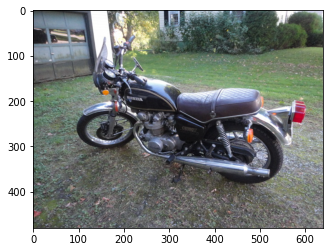

Caption:
 life grassland grassland grassland grassland grassland grassland grassland emits emits emits emits emits rentals rentals rentals rentals rentals rentals rentals rentals tightly tightly follows rinsed follows meal revealing macaroni papers


In [ ]:
Generate_caption('/content/drive/MyDrive/MSCOCO_2017/val2017/000000179765.jpg')

# 評估模型準確度 Evaluate model
用來產生 BLEU, METEOR, ROUGE_L, CIDEr 分數

### 產生 validation set 的所有圖片的預測結果

In [11]:
# 取得不重複的 val 圖片檔名列表
val_anno_path = '/content/drive/MyDrive/MSCOCO_2017/2017_annotations/captions_val2017.json'
input_file = open(anno_path)
val_annotation = json.load(input_file)

id_list = set()
for cap in val_annotation['annotations']:
  id_list.add(cap['image_id'])

In [12]:
len(id_list)

5000

In [15]:
# 評分資料格式在 https://cocodataset.org/#format-data 的 5. Image Captioning 大標下有規定
results = list()
for id in tqdm(id_list):  # 多加個 tqdm 是為了看他印出漂亮的進度條
  one_result = dict()
  complete_path = img_path + '/%012d.jpg' % id
  cap = Generate_caption(complete_path, False)
  one_result["image_id"] = id
  one_result["caption"] = cap
  results.append(one_result)


 54%|█████▍    | 2695/5000 [1:06:01<51:59,  1.35s/it]

KeyError: ignored

In [16]:
len(results)

2695

In [17]:
generated_caption_path = "generated_caption_val2017.json"
with open(generated_caption_path, 'w') as jsonfile:
  json.dump(results, jsonfile)

In [ ]:
# 產生假的完美結果，測試用

'''
added_caps = set()
results = list()
for cap in annotation['annotations']:
  if cap['image_id'] not in added_caps:
    added_caps.add(cap['image_id'])
    one_result = dict()
    one_result["image_id"] = cap["image_id"]
    one_result["caption"] = cap["caption"]
    results.append(one_result)
  
generated_caption_path = "generated_caption_val2017.json"
with open(generated_caption_path, 'w') as jsonfile:
  json.dump(results, jsonfile)
'''

### coco-caption evaluation
從 GitHub 抓別人寫好的評分模組   
官方版是 tylin/coco-caption ，而 davidfsemedo 是相容 Python 3 的修改版本

In [18]:
!git clone https://github.com/davidfsemedo/coco-caption


Cloning into 'coco-caption'...
remote: Enumerating objects: 737, done.
remote: Total 737 (delta 0), reused 0 (delta 0), pack-reused 737
Receiving objects: 100% (737/737), 106.72 MiB | 41.63 MiB/s, done.
Resolving deltas: 100% (400/400), done.


In [19]:
import os, sys
sys.path.insert(0,"/content/coco-caption")

In [22]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')


In [23]:
#  workaround provided by https://github.com/tylin/coco-caption/issues/26#issuecomment-439825144
modified_anno_path = "/content/modified_captions_val2017.json"

with open(anno_path, 'r') as f:
    data = json.load(f)
    data['type'] = 'captions'
with open(modified_anno_path, 'w') as f:
    json.dump(data, f)

In [24]:
coco = COCO(modified_anno_path)
cocoRes = coco.loadRes(generated_caption_path)

loading annotations into memory...
0:00:00.036594
creating index...
index created!
Loading and preparing results...     
DONE (t=0.01s)
creating index...
index created!


In [25]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(coco, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
cocoEval.evaluate()

tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 28347, 'reflen': 27259, 'guess': [28347, 25652, 22957, 20262], 'correct': [11694, 2856, 710, 265]}
ratio: 1.0399134230895837
Bleu_1: 0.413
Bleu_2: 0.214
Bleu_3: 0.112
Bleu_4: 0.066
computing METEOR score...
METEOR: 0.104
computing Rouge score...
ROUGE_L: 0.320
computing CIDEr score...
CIDEr: 0.105


In [26]:
# print output evaluation scores
for metric, score in cocoEval.eval.items():
    print('%s: %.3f'%(metric, score))

Bleu_1: 0.413
Bleu_2: 0.214
Bleu_3: 0.112
Bleu_4: 0.066
METEOR: 0.104
ROUGE_L: 0.320
CIDEr: 0.105
